# Machine Learning for Drug Discovery - in 2 minutes!

In [ ]:
#%%capture
# from __future__ import division

# import numpy as np
# import pandas as pd
# from numpy.linalg import eigvalsh,eigh
from rdkit import Chem
# from rdkit.Chem.rdmolops import GetAdjacencyMatrix
# from rdkit.Chem.EState import Fingerprinter
# from rdkit.Chem import Descriptors
# from rdkit.Chem.rdmolops import RDKFingerprint
# from rdkit.Chem import AllChem
# from rdkit.Chem.Crippen import MolLogP,MolMR
# from sklearn import cross_validation
# from sklearn.gaussian_process import GaussianProcessRegressor
# from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
# from sklearn.gaussian_process.kernels import Matern, WhiteKernel, ConstantKernel
# from sklearn.model_selection import GridSearchCV
# import scipy as sp
# from sklearn.base import BaseEstimator
# from sklearn.grid_search import GridSearchCV
# import matplotlib.pyplot as plt
# import seaborn as sns
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import scale,normalize
# import networkx as nx

# import ES_ML_SOSSO.chemfun as cf


# import matplotlib.pyplot as plt # useful to plot data
# from sklearn.model_selection import train_test_split
# import networkx as nx
# from numpy import linalg as LA
# % matplotlib inline
# from rdkit import Chem
# from rdkit.Chem.Draw import IPythonConsole #Needed to show molecules
# from rdkit.Chem.Draw.MolDrawing import MolDrawing, DrawingOptions #Only needed if modifying defaults
# DrawingOptions.bondLineWidth=1.8
print('ok')

##  The dataset
The dataset we are going to use can be downloaded for free at http://moleculenet.ai/datasets-1. It contains the solubility in $\log[\text{mols/litre}]$ of (1128) common organic small molecules in water.

In [6]:
# We load the dataset into the notebook, specifically into the "data" variable
# using the panda library ("import pandas as pd" above).
# Specifically, we'll use the read_table function, hence...
data=pd.read_table("./ES_ML_SOSSO/dataset.dat",header=None)

In [8]:
# Let's have a look at our dataset
print(data)

                                                      0      1
0     OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)... -0.770
1                                Cc1occc1C(=O)Nc2ccccc2 -3.300
2                                  CC(C)=CCCC(C)=CC(=O) -2.060
3                    c1ccc2c(c1)ccc3c2ccc4c5ccccc5ccc43 -7.870
4                                               c1ccsc1 -1.330
5                                        c2ccc1scnc1c2  -1.500
6                    Clc1cc(Cl)c(c(Cl)c1)c2c(Cl)cccc2Cl -7.320
7                      CC12CCC3C(CCc4cc(O)ccc34)C2CCC1O -5.030
8        ClC4=C(Cl)C5(Cl)C3C1CC(C2OC12)C3C4(Cl)C5(Cl)Cl -6.290
9      COc5cc4OCC3Oc2c1CC(Oc1ccc2C(=O)C3c4cc5OC)C(C)=C  -4.420
10                                            O=C1CCCN1  1.070
11                                     Clc1ccc2ccccc2c1 -4.140
12                                               CCCC=C -2.680
13                           CCC1(C(=O)NCNC1=O)c2ccccc2 -2.640
14                                       CCCCCCCCCCCCCC

## The SMILES format
Our database contains 1128 lines, one line / molecule. In each line, we have the structure of the molecule (1st column) and its solubility (2nd column). The structure is encoded in the so-called SMILES format (https://en.wikipedia.org/wiki/Simplified_molecular-input_line-entry_system), which contains a limited amount of information about the structure - chiefly the identity of the atoms and their connectivity (i.e. which bonds are helding them together). A SMILES structure is thus 2D representation of a molecule - let's have a look...

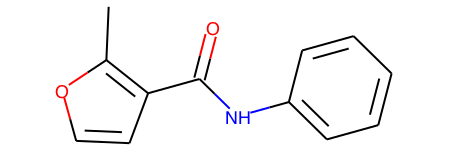

In [7]:
from rdkit.Chem.Draw import IPythonConsole #Needed to show molecules

# We store the SMILES for each molecules in to the "smiles" (1D) array
# "data[0].values" gets the values of first column ([0], note that in Python we start counting from 0, not 1!) 
# of the (2D) "data" array 
smiles=data[0].values

# Let's do the same with the solubility values - this time, 2nd column, so data[1].values
logS=data[1].values

# Draw the structure from the second [1] SMILES 
test_mol=Chem.MolFromSmiles(smiles[1])

# Visualize the structure
test_mol

<div class=warn>
Add hydrogen atoms to the structure of the last molecule within the dataset and visualize the result
<div/>

In [8]:
# Setting indices to know how data is split 
indices=np.arange(len(smiles))

In [9]:
# Load saved train/test sets
Train=np.load('./ES_ML_SOSSO/Train.npy')
Test=np.load('./ES_ML_SOSSO/Test.npy')
TrainTargets=np.load('./ES_ML_SOSSO/TrainTargets.npy')
TestTargets=np.load('./ES_ML_SOSSO/TestTargets.npy')

In [10]:
# Convert into a different format (rdkit internal)
MFSTR=cf.SMILES2MOLES(Train)
MFSTE=cf.SMILES2MOLES(Test)

In [11]:
# Choosing the descriptors for training (SDTR) and test (SDTE) sets. 
from rdkit.Chem import Descriptors

SDTR=[]
for m in MFSTR:
    desc=[]
    desc.append(Chem.Lipinski.NumAromaticRings(m)) # Number of aromatic rings
    desc.append(Chem.Lipinski.NumHAcceptors(m))    # Number of hydrogen bond acceptors
    desc.append(Chem.Lipinski.HeavyAtomCount(m))   # Number of heavy atoms within the molecule
    desc.append(Descriptors.TPSA(m))               # from J. Med. Chem. 43:3714-7, (2000)
    SDTR.append(desc)

SDTE=[]
for m in MFSTE:
    desc=[]
    desc.append(Chem.Lipinski.NumAromaticRings(m)) 
    desc.append(Chem.Lipinski.NumHAcceptors(m))
    desc.append(Chem.Lipinski.HeavyAtomCount(m))
    desc.append(Descriptors.TPSA(m))
    SDTE.append(desc)

<div class=warn>

* Modify the list of descriptors using rdkit built-in descriptors (a list can be found [here](http://www.rdkit.org/docs/GettingStartedInPython.html#list-of-available-descriptors))<br>
* Motivate your choice (in a Markdown cell)

<div/>

In [12]:
# Use a Gaussian process (GP) to fit our training set

# Choosing the kernel: radial basis function, initial lengthscale =1
# Note that we are setting boundaries for the lengthscale - to avoid overfitting
# There are obviously better ways to do this...
kernel=RBF(length_scale_bounds=(5e-02,10)) 

# Define our GP
# normalize_y=True -> the mean of the observed target values is set to zero

# To try and avoid finding a local, rather than a global, maximum in the marginal likelihood
# n_restarts_optimizer > 0, which will run the optimization algorithm as many times as specified,
# using randomly-chosen starting coordinates, in the hope that a globally-competitive value can be discovered

# Add some noise to the actual data - useful to improve the numerical accuracy of the fitting

gp=GaussianProcessRegressor(kernel=kernel,normalize_y=True,n_restarts_optimizer=10,alpha=1e-4);

# Fit our GP model
gp.fit(SDTR,TrainTargets);

In [13]:
# Use the trained GP to predict the solubility of our training set...
TrainPred=gp.predict(SDTR).reshape(-1,1)
# ... and of our test set
TestPred=gp.predict(SDTE).reshape(-1,1)
# The reshape(-1,1) bit is needed to convert numpy arrays into scikit-learn compatible inputs...

In [14]:
from sklearn.metrics import mean_squared_error

# How are we doing? 
# Let us calculate the mean squared error of our prediction for the training set 
# with respect to the actual solubility values
mse_train=mean_squared_error(TrainTargets,TrainPred)
print("MSE (training)) = ", mse_train)

# Now let's do the same for the test set...
mse_test=mean_squared_error(TestTargets,TestPred)
print("MSE (test)) = ", mse_test)

MSE (training)) =  0.1131850437610568
MSE (test)) =  1.385867708323086


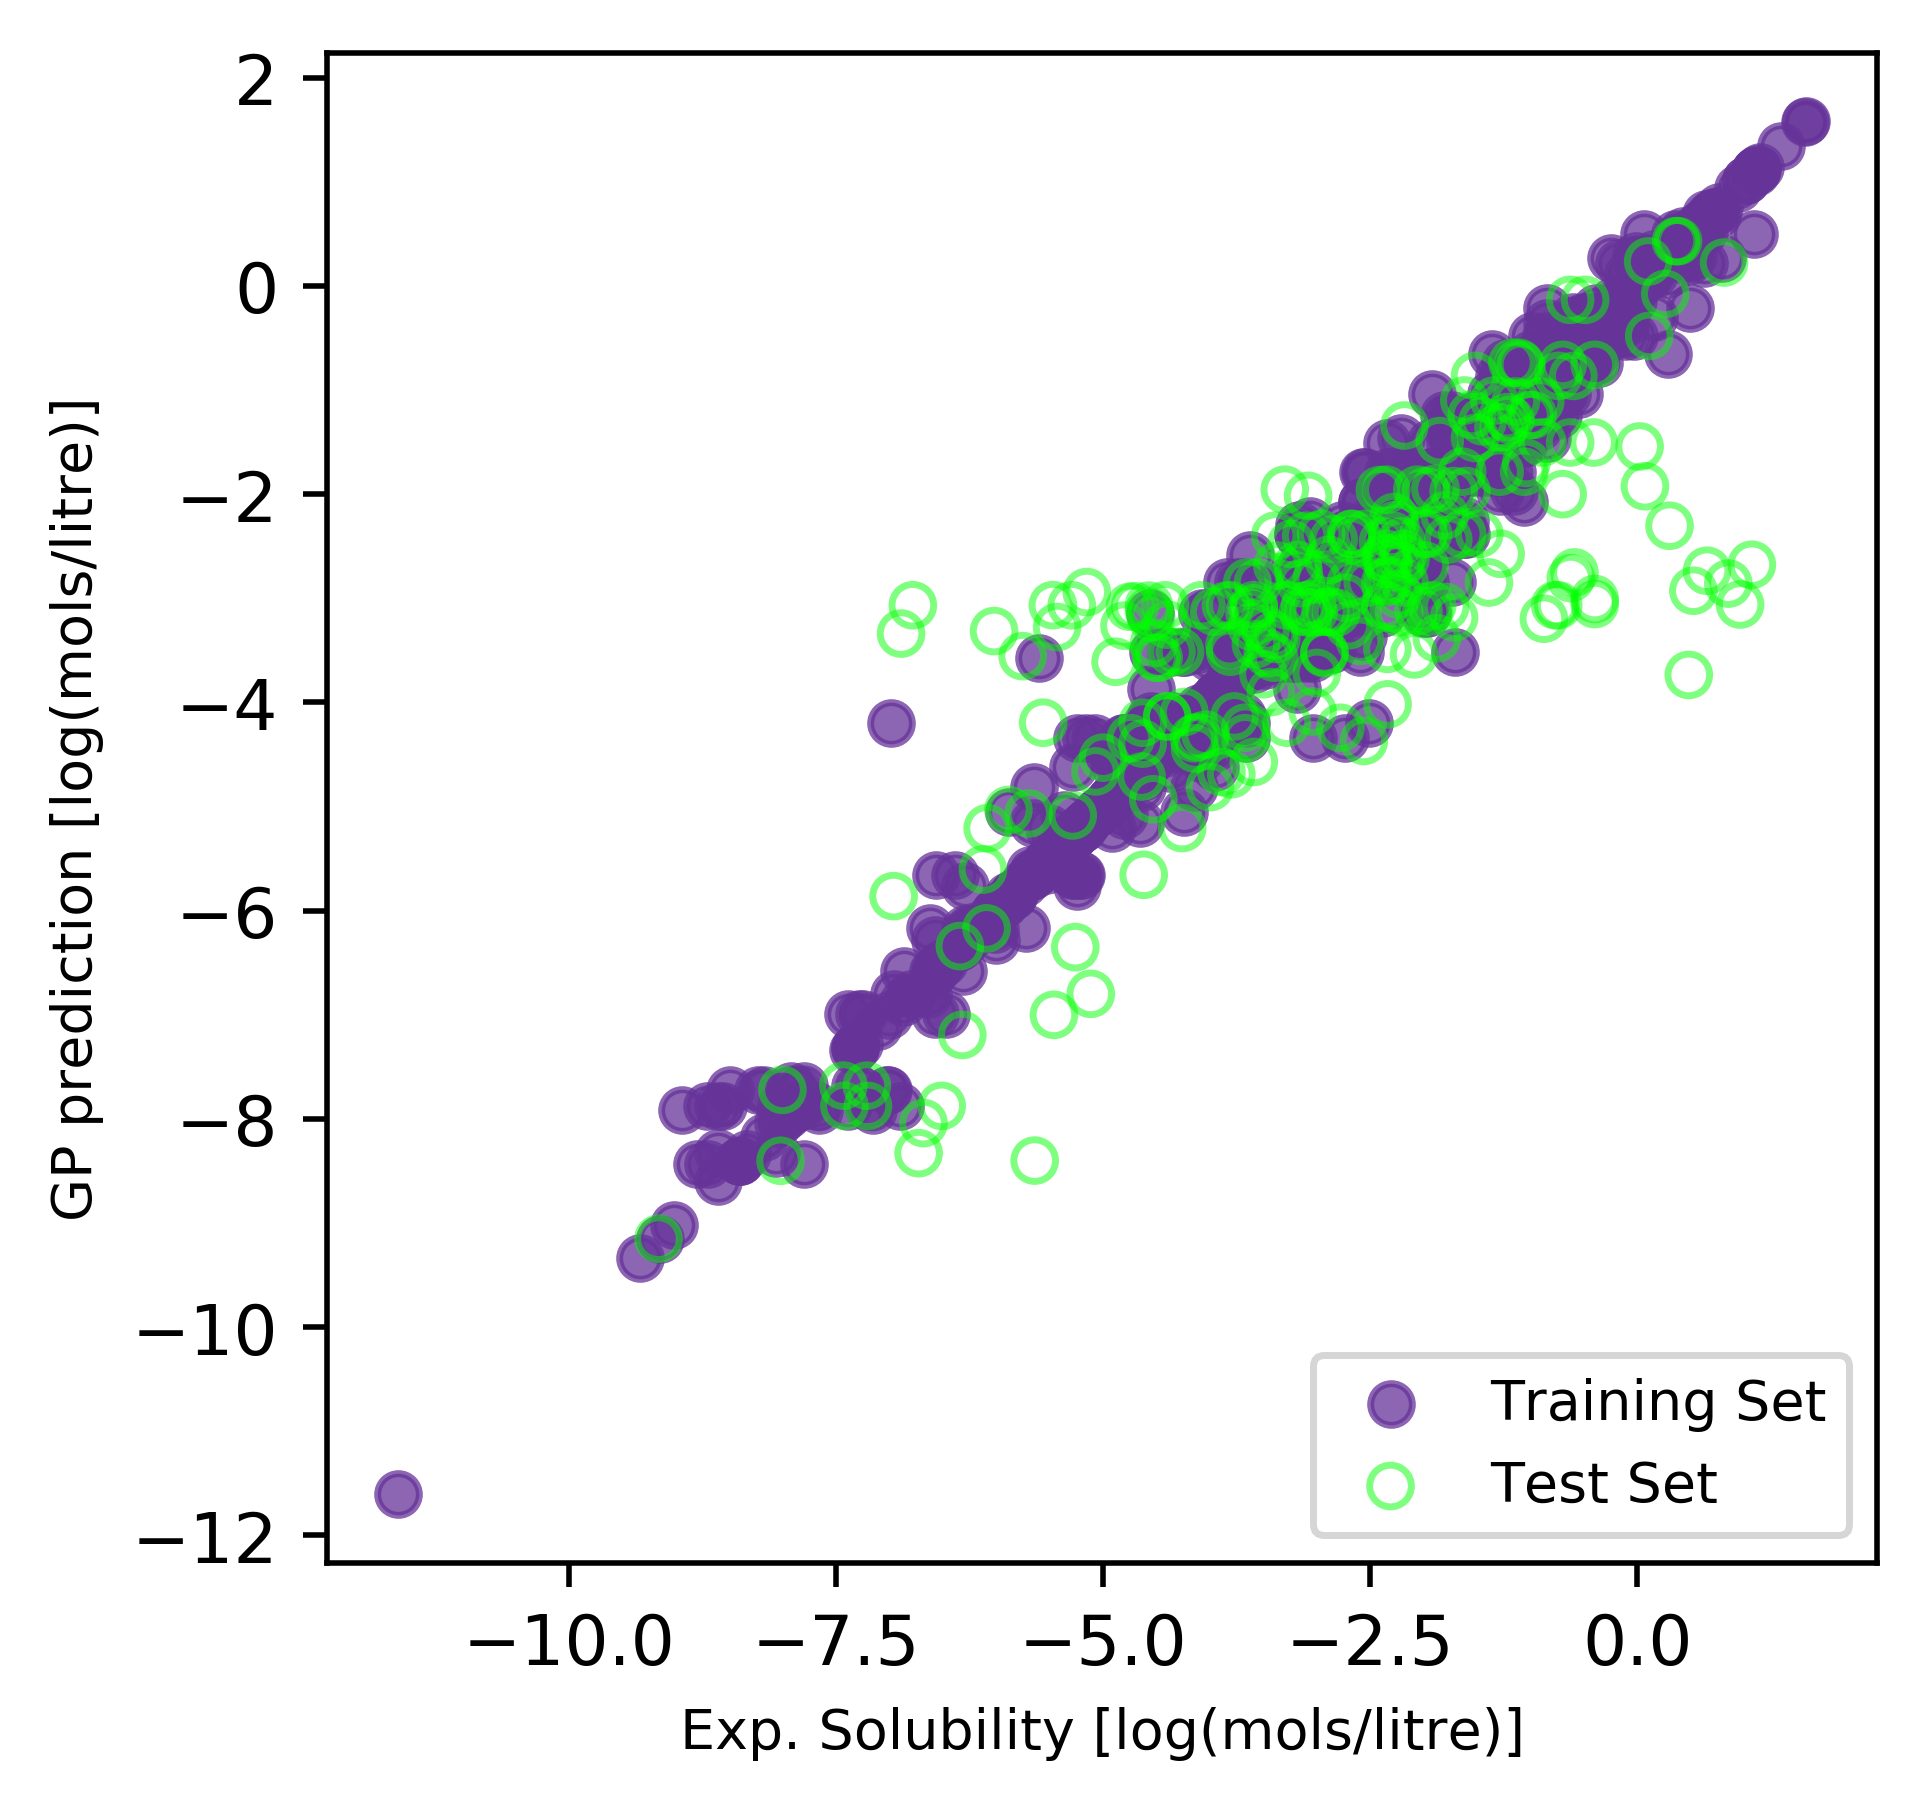

In [15]:
# Let's have a look!
fig=plt.figure(num=None,figsize=(4,4),dpi=500,facecolor='w',edgecolor='k')
plt.xlabel('Exp. Solubility [log(mols/litre)]',fontsize=8)
plt.ylabel('GP prediction [log(mols/litre)]',fontsize=8)
plt.scatter(TrainTargets,TrainPred,color='rebeccapurple',alpha=0.75,label='Training Set')
plt.scatter(TestTargets,TestPred,color='lime',alpha=0.5,label='Test Set',facecolors='none')
plt.legend(fontsize=8,loc=4);
#plt.savefig('4.png');

<div class=warn>
<h2>Assessed part of the workshop</h2>
    <i>If you don't know it... Google it!</i>
* <b>Step 1</b>: Import the "Lipophilicity" dataset from [http://moleculenet.ai/](http://moleculenet.ai/) <br>
* <b>Step 2</b>: Split the dataset, by (randomly!) assigning 70% of the structure to the trainining set and 30% to the test set.<br>
* <b>Step 3</b>: Plot the probability density function of the target values for both the training and the test dataset <br>
* <b>Step 4</b>: Choose your descriptors: [this paper](https://onlinelibrary.wiley.com/doi/abs/10.1002/cmdc.200700041) can provide a starting point. <br>
* <b>Step 5</b>: Fit a Gaussian Process using a Matérn kernel (setting the initial value of the lengthscale to 1 and the initial value of the hyperparameter $\nu$ to 1.5) in combination with a White kernel (setting the initial value of the noise level to 1) <br>
* <b>Step 6</b>: Visualize the result via a scatter plot (GP prediction vs Exp. Lipophilicity) including training and test sets predictions.<br>
* <b>Step 7</b>: Optimize the value of $\nu$ according to the mean squared error of the predictions for the dataset<br>
* <b>Step 8</b>: Visualize the (hopefully improved) result via a scatter plot (GP prediction vs Exp. Lipophilicity) including training and test sets predictions.<br>    
<div/>